In [1]:
import numpy as np
import matplotlib.pyplot as plt

from lab2_proto import *
from lab2_tools import *

from prondict import *

In [2]:
data = np.load('lab2_data.npz', allow_pickle=True)['data']

In [3]:
phoneHMMs_one = np.load('lab2_models_onespkr.npz', allow_pickle=True)['phoneHMMs'].item()
phoneHMMs_all = np.load('lab2_models_all.npz', allow_pickle=True)['phoneHMMs'].item()

In [4]:
isolated = {}
for digit in prondict.keys():
    isolated[digit] = ['sil'] + prondict[digit] + ['sil']

In [5]:
wordHMMs = {}
wordHMMs['o'] = concatHMMs(phoneHMMs_one, isolated['o'])
wordHMMs['o'].keys()

dict_keys(['startprob', 'transmat', 'means', 'covars'])

In [6]:
example = np.load('lab2_example.npz', allow_pickle=True)['example'].item()
list(example.keys())

['filename',
 'samplingrate',
 'gender',
 'speaker',
 'digit',
 'repetition',
 'samples',
 'lmfcc',
 'obsloglik',
 'logalpha',
 'loglik',
 'vloglik',
 'vpath',
 'logbeta',
 'loggamma']

## 5.1 Gaussian emission probabilities

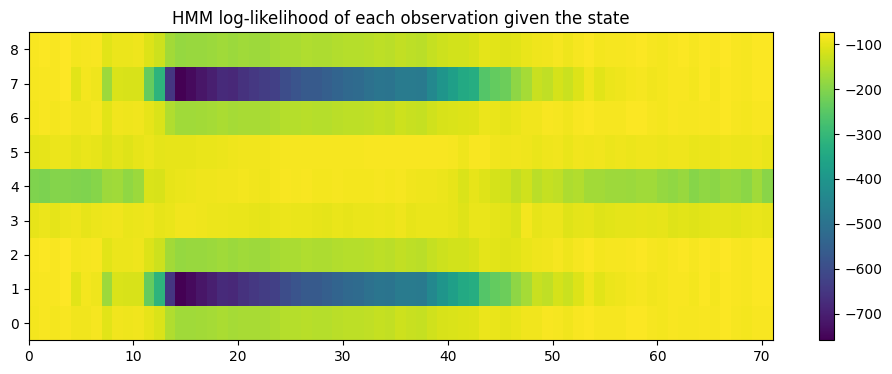

In [24]:
obsloglik = log_multivariate_normal_density_diag(example['lmfcc'], wordHMMs['o']['means'], wordHMMs['o']['covars'])
plt.figure(figsize=(12, 4))
plt.pcolormesh(obsloglik.T)
plt.colorbar()
plt.title("HMM log-likelihood of each observation given the state")
plt.yticks(np.arange(9) + 0.5, np.arange(9))

assert np.allclose(obsloglik, example['obsloglik'])

In [8]:
# Compute the log likelihood of the emission probabilities for each state




## 5.2 Forward algorithm

In [ ]:
def forward(log_emlik, log_startprob, log_transmat):
    """Forward (alpha) probabilities in log domain.

    Args:
        log_emlik: NxM array of emission log likelihoods, N frames, M states
        log_startprob: log probability to start in state i
        log_transmat: log transition probability from state i to j

    Output:
        forward_prob: NxM array of forward log probabilities for each of the M states in the model
    """
    N, M = log_emlik.shape
    log_alpha = np.zeros((N, M))
    print(N, M)
    log_alpha[0] = log_startprob + log_emlik[0]
    for n in range(1, N):
        for j in range(M):
            log_alpha[n, j] = log_emlik[n, j] + logsumexp(log_alpha[n-1] + log_transmat[:, j])
    return log_alpha

In [32]:
wordHMMs['o']['startprob'].shape, wordHMMs['o']['transmat'].shape, obsloglik.shape

((10,), (10, 10), (71, 9))

C:\Users\elioc\AppData\Local\Temp\ipykernel_10120\1657760812.py:1: RuntimeWarning: divide by zero encountered in log
  log_alpha = forward(obsloglik, np.log(wordHMMs['o']['startprob'])[:-1], np.log(wordHMMs['o']['transmat'][:-1, :-1]))


71 9


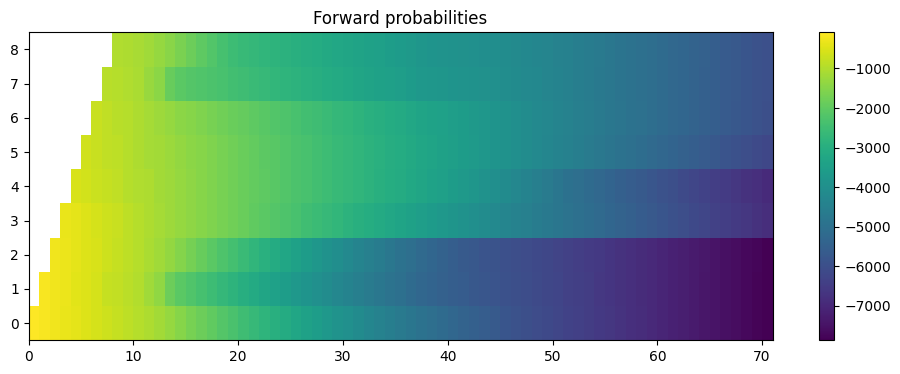

In [57]:
log_alpha = forward(obsloglik, np.log(wordHMMs['o']['startprob'])[:-1], np.log(wordHMMs['o']['transmat'][:-1, :-1]))

plt.figure(figsize=(12, 4))
plt.pcolormesh(log_alpha.T)
plt.colorbar()
plt.yticks(np.arange(9) + 0.5, np.arange(9))
plt.title("Forward probabilities")

assert np.allclose(log_alpha, example['logalpha'])

C:\Users\elioc\AppData\Local\Temp\ipykernel_10120\2737017431.py:20: RuntimeWarning: divide by zero encountered in log
  log_beta = backward(obsloglik, np.log(wordHMMs['o']['startprob'])[:-1], np.log(wordHMMs['o']['transmat'][:-1, :-1]))


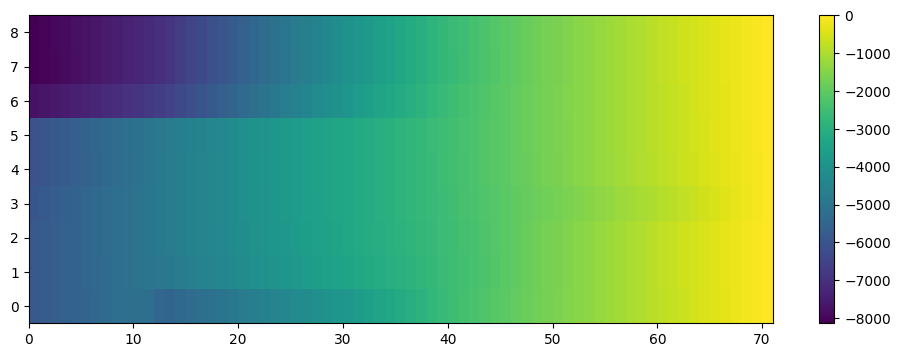

In [58]:
def backward(log_emlik, log_startprob, log_transmat):
    """Backward (beta) probabilities in log domain.

    Args:
        log_emlik: NxM array of emission log likelihoods, N frames, M states
        log_startprob: log probability to start in state i
        log_transmat: transition log probability from state i to j

    Output:
        backward_prob: NxM array of backward log probabilities for each of the M states in the model
    """
    backward_prob = np.zeros(log_emlik.shape)
    N, M = log_emlik.shape
    backward_prob[-1] = 0
    for n in range(N-2, -1, -1):
        for i in range(M):
            backward_prob[n, i] = logsumexp(log_emlik[n+1] + log_transmat[i] + backward_prob[n+1])
    return backward_prob

log_beta = backward(obsloglik, np.log(wordHMMs['o']['startprob'])[:-1], np.log(wordHMMs['o']['transmat'][:-1, :-1]))
plt.figure(figsize=(12, 4))
plt.pcolormesh(log_beta.T)
plt.yticks(np.arange(9) + 0.5, np.arange(9))
plt.colorbar()

assert np.allclose(log_beta, example['logbeta'])

In [60]:
def viterbi(log_emlik, log_startprob, log_transmat, forceFinalState=True):
    """Viterbi path.

    Args:
        log_emlik: NxM array of emission log likelihoods, N frames, M states
        log_startprob: log probability to start in state i
        log_transmat: transition log probability from state i to j
        forceFinalState: if True, start backtracking from the final state in
                  the model, instead of the best state at the last time step

    Output:
        viterbi_loglik: log likelihood of the best path
        viterbi_path: best path
    """
    log_V = np.zeros(log_emlik.shape)
    N, M = log_emlik.shape
    
    log_V[0] = log_startprob + log_emlik[0]
    for n in range(1, N):
        for j in range(M):
            log_V[n, j] = log_emlik[n, j] + np.max(log_V[n-1] + log_transmat[:, j])    
    
    if forceFinalState:
        best_state = len(log_V[-1]) - 1
    else:
        best_state = np.argmax(log_V[-1])

    viterbi_loglik = log_V[-1][best_state]

    viterbi_path = np.zeros(N, dtype=int)
    viterbi_path[-1] = best_state
    
    for n in range(N-2, -1, -1):
        best_state = np.argmax(log_V[n])
        viterbi_path[n] = best_state
    
    return viterbi_loglik, viterbi_path

log_V, viterbi_path = viterbi(obsloglik, np.log(wordHMMs['o']['startprob'])[:-1], np.log(wordHMMs['o']['transmat'][:-1, :-1]), forceFinalState=True)
assert np.allclose(log_V, example['vloglik'])

C:\Users\elioc\AppData\Local\Temp\ipykernel_10120\2542440187.py:39: RuntimeWarning: divide by zero encountered in log
  log_V, viterbi_path = viterbi(obsloglik, np.log(wordHMMs['o']['startprob'])[:-1], np.log(wordHMMs['o']['transmat'][:-1, :-1]), forceFinalState=True)


Text(0.5, 1.0, 'State posterior probabilities')

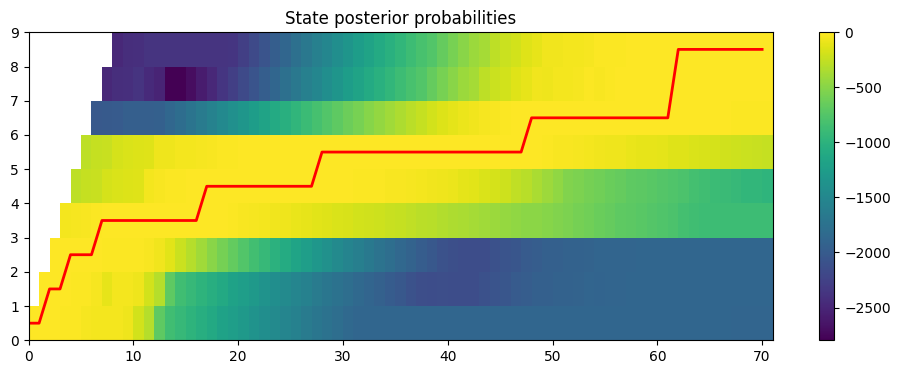

In [54]:
def statePosteriors(log_alpha, log_beta):
    """State posterior (gamma) probabilities in log domain.

    Args:
        log_alpha: NxM array of log forward (alpha) probabilities
        log_beta: NxM array of log backward (beta) probabilities
    where N is the number of frames, and M the number of states

    Output:
        log_gamma: NxM array of gamma probabilities for each of the M states in the model
    """
    log_gamma = log_alpha + log_beta
    log_gamma -= logsumexp(log_gamma, axis=1)[:, np.newaxis]
    return log_gamma

log_gamma = statePosteriors(log_alpha, log_beta)
plt.figure(figsize=(12, 4))
plt.pcolormesh(log_gamma.T)
plt.colorbar()
plt.plot(viterbi_path+0.5, 'r', lw=2)
plt.title("State posterior probabilities")